In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

In [2]:
df = pd.read_csv('../data/training_results.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/training_results.csv'

In [ ]:
df[(df.n_way==10 )& (df.dataset=='flickr8k')] 

In [ ]:
plot_df_1 = df[(df.n_way==50)&(df.n_class_additions==5)&(df.n_classes_start==5)&(df.algorithm=='FSCL')&(df.dataset=='flickr8k')].\
    drop(columns=['Name']).groupby(['k_shot']).max().reset_index(drop=False)
plot_df_2 = df[(df.n_way==10)&(df.n_class_additions==1)&(df.n_classes_start==2)&(df.algorithm=='FSCL')&(df.dataset=='google_commands')].\
    drop(columns=['Name']).groupby(['k_shot']).max().reset_index(drop=False)
plot_df = pd.concat([plot_df_1, plot_df_2])

def rename_(name):
    if name == 'flickr8k':
        return 'Flickr8k: N=50, CA=5, CS=5'
    else:
        return "Google Commands: N=10, CA=2, CS=2"

plot_df['dataset']=plot_df['dataset'].apply(rename_)
plot_df.rename(columns={'k_shot':'K-Shot', 'validation_query_accuracy_epoch':'Final Accuracy', 'dataset':'Dataset'}, inplace=True)

plt.figure(figsize=(20, 10))
# set colours allowed to use to certain hex value
sns.set_palette(sns.color_palette(["#1D2140", "#17C37B"])) 
sns.barplot(x='K-Shot', y='Final Accuracy', hue='Dataset', data=plot_df)
#add the value on top of the bar
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2., p.get_height(), '{:1.2f}'.format(p.get_height()*100), fontsize=18, color='black', ha='center', va='bottom')

# make the legend text bigger
plt.legend(loc='lower right', prop={'size': 20})
# make plot font size bigger
plt.rcParams.update({'font.size': 22})

# remove top grid line
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('k_shot_accuracy.png', transparent=True, pad_inches=.2, frameon=False)
plt.show()

# Generate CL insights

In [3]:
from src.models import WordClassificationAudio2DCnn, WordClassificationAudioCnnPool as WordClassificationAudioCnn, WordClassificationRnn
from src.losses import ClassificationLoss
from src.algorithms import FSCL, OML
from src.data.datasets import Flickr8kWordClassification, GoogleCommandsWordClassification
from src.data.samplers import SpokenWordTaskBatchSampler
from src.utils import flatten_dict

import torch.nn as nn
import torch

c:\Users\ruanv\miniconda3\envs\flickr2\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\ruanv\miniconda3\envs\flickr2\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [4]:
optim = {
'name': 'adam',
'inner_steps': 5,
'val_inner_steps': 5,
'gradient_clip_val': 0,
'inner_learning_rate': 0.001,
'outer_learning_rate': 0.0001,
'scheduler': False,
'scheduler_step': 30,
'scheduler_decay': 0.1,
}

encoder = WordClassificationAudio2DCnn(
    256, 
    64, 
    input_channels=39
)

class FSCLModel(nn.Module):
    def __init__(self, encoder, embedding_dim, n_classes):
        super().__init__()

        self.encoder = encoder

        def return_classification_layer(embedding_dim):
            layer = nn.Linear(embedding_dim, 1)
            torch.nn.init.xavier_uniform(layer.weight, )
            layer = nn.Sequential(
                nn.ReLU(),
                layer
            )
            return layer

        layers = [return_classification_layer(embedding_dim) for _ in range(n_classes)]
        self.classifiers = nn.ModuleList(layers)

    def forward(self, audio, total_classes_present):
        features = self.encoder(audio)
        layer_logits = []
        for c_layer in range(total_classes_present):
            layer_logits.append(self.classifiers[c_layer](features))
        logits = torch.cat(layer_logits, dim=1)
        return {'logits':logits}


loss_fn = ClassificationLoss()

model = FSCLModel(encoder, 256, 50)
algorithm = FSCL.load_from_checkpoint(
    './nway50_k5.ckpt', 
    model=model, 
    training_steps=5,
    intial_training_steps=30,
    n_classes_start=5,
    n_class_additions=5,
    loss_func=loss_fn,
    optim_config=optim,
    k_shot=5,
    quick_adapt=True
)
model = algorithm.model

C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


In [5]:
df = pd.read_csv('C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/flickr8k_word_splits_validation.csv')


In [6]:
import yaml

with open('../config/conversion_method/mfcc.yaml') as f:
    conv_config = yaml.safe_load(f) 

valiadation_dataset = Flickr8kWordClassification(
    meta_path='C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/flickr8k_word_splits_validation.csv',
    audio_root='C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/wavs/', 
    conversion_config=conv_config,
    stemming=True, 
    lemmetise=False          
)


def pad_audio(x, max_audio_len=101, pad_both_sides=False):
    import torch.nn.functional as F
    if x.size(-1) > max_audio_len:
        x = x[:,:max_audio_len]
    else:
        if pad_both_sides:
            pad_lenght = int(max_audio_len-x.size(-1))//2
            x = F.pad(x, (pad_lenght, pad_lenght+1 if int(max_audio_len-x.size(-1))%2!=0 else pad_lenght), 'constant', 0)
        else:
            x = F.pad(x, (0, int(max_audio_len-x.size(-1))), 'constant', 0)
    return x



Loading audio: 100%|██████████| 32974/32974 [00:00<00:00, 388835.57it/s]


In [7]:
N_CLASSES = [5,10]
K_SHOT = [5,10,20,50]
UPDATES = [True, False]

LR = 0.0001
N_TRAINING_STEPS = 30

In [8]:
for N in N_CLASSES:
    for K in K_SHOT:
        for UPDATE in UPDATES:

            print(N, K, UPDATE)

            df = pd.read_csv('C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/flickr8k_word_splits_validation.csv')
            words_keep = [
            'surf', 'wave', 'crowd', 'fight', 'togeth', 'ski',
            'bridg', 'wood', 'teenag', 'lot', 'mud', 'pool', 'tabl', 'out',
            'wet', 'footbal', 'make', 'team', 'shop', 'their', 'edg', 'guitar',
            'across', 'area', 'do', 'trick', 'bike', 'obstacl', 'tri', 'rider',
            'track', 'room', 'him', 'jacket', 'glass', 'open', 'them', 'cap',
            'color', 'set', 'pant', 'wrestl', 'basketbal', 'climber', 'face',
            'mountain', 'tent', 'shore', 'ground', 'bar'
            ]
            df = df[df.stem.isin(words_keep)]

            # sample 5 instances of each stem
            df = df.groupby('stem').apply(lambda x: x.sample(K)).reset_index(drop=True)
            df.to_csv('./plot_data_words.csv', index=False)


            valiadation_dataset = Flickr8kWordClassification(
                meta_path='plot_data_words.csv',
                audio_root='C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/wavs/', 
                conversion_config=conv_config,
                stemming=True, 
                lemmetise=False          
            )

            file_name = f'nway{N}_k{K}_update{UPDATE}_MAMLCON.csv'

            STEPS = K*N


            groups = []
            test_groups = []

            for i in range(0, len(valiadation_dataset), STEPS):
                arrays = []
                labels = []

                for j in range(0+i, STEPS+i):
                    arrays.append(pad_audio(torch.tensor(valiadation_dataset[j][0])).unsqueeze(0))
                    labels.append(torch.tensor(valiadation_dataset[j][1]))
                
                arrays = torch.concat(arrays,dim=0)

                # take every 5th instance as test
                test_arrays = arrays[::N]
                test_labels = labels[::N]

                # skip every 5th instance
                arrays = torch.concat([array.unsqueeze(0) for i, array in enumerate(arrays) if i%N!=0 or i==0],dim=0)
                labels = [label for i, label in enumerate(labels) if i%N!=0 or i==0]

                groups.append({'data':arrays, 'labels':labels})
                test_groups.append({'data':test_arrays, 'labels':test_labels})

            results = pd.DataFrame()

            model = FSCLModel(encoder, 256, 50)
            algorithm = FSCL.load_from_checkpoint(
                './nway50_k5.ckpt', 
                model=model, 
                training_steps=5,
                intial_training_steps=30,
                n_classes_start=5,
                n_class_additions=5,
                loss_func=loss_fn,
                optim_config=optim,
                k_shot=5,
                quick_adapt=True
            )
            model = algorithm.model

            criterion = ClassificationLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=LR)

            # Training loop
            for n, group in enumerate(groups):
                model.train()
                data, labels = group['data'], group['labels']
                for i in range(N_TRAINING_STEPS):
                    # Clear gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = model(data, (n+1)*N)
                    outputs['labels'] = torch.tensor(labels)
                    # Compute loss
                    loss = criterion(outputs)
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
                        
                # Print loss for each epoch
                # print(f'Training loss: {loss.item():.4f}')

                if UPDATE:

                    for group in groups[:n+1]:
                        data, labels = group['data'], group['labels']
                        optimizer.zero_grad()

                        # take every 5th instance
                        data = data[::5]
                        labels = labels[::5]

                        # Forward pass
                        outputs = model(data, (n+1)*N)
                        outputs['labels'] = torch.tensor(labels)
                        # Compute loss
                        loss = criterion(outputs)
                        
                        # Backward pass and optimization
                        loss.backward()
                        optimizer.step()

                with torch.no_grad():
                    model.eval()

                    for i, group in enumerate(test_groups[:n+1]):
                        data, labels = group['data'], group['labels']
                        outputs = model(data, (i+1)*N)
                        outputs['labels'] = torch.tensor(labels)
                        loss = criterion(outputs)

                        predicted_labels = torch.argmax(outputs['logits'], dim=1)
                        accuracy = torch.sum(predicted_labels == torch.tensor(labels)).item() / len(labels)

                        results = pd.concat([results,pd.DataFrame({'loss':[loss.item()], 'accuracy':[accuracy], 'group':[i], 'training_group':[n]})])
                        results.to_csv(file_name, index=False)


5 5 True


Loading audio: 100%|██████████| 250/250 [00:00<00:00, 259163.62it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


5 5 False


Loading audio: 100%|██████████| 250/250 [00:00<00:00, 125337.80it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


5 10 True


Loading audio: 100%|██████████| 500/500 [00:00<00:00, 250615.68it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


5 10 False


Loading audio: 100%|██████████| 500/500 [00:00<00:00, 250645.63it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


5 20 True


Loading audio: 100%|██████████| 1000/1000 [00:00<00:00, 334287.40it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


5 20 False


Loading audio: 100%|██████████| 1000/1000 [00:00<00:00, 334180.86it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


5 50 True


Loading audio: 100%|██████████| 2500/2500 [00:00<00:00, 227881.95it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


5 50 False


Loading audio: 100%|██████████| 2500/2500 [00:00<00:00, 358107.99it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


10 5 True


Loading audio: 100%|██████████| 250/250 [00:00<00:00, 250675.59it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


10 5 False


Loading audio: 100%|██████████| 250/250 [00:00<00:00, 125322.82it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


10 10 True


Loading audio: 100%|██████████| 500/500 [00:00<00:00, 250555.79it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


10 10 False


Loading audio: 100%|██████████| 500/500 [00:00<00:00, 167130.38it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


10 20 True


Loading audio: 100%|██████████| 1000/1000 [00:00<00:00, 200521.30it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


10 20 False


Loading audio: 100%|██████████| 1000/1000 [00:00<00:00, 250675.59it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


10 50 True


Loading audio: 100%|██████████| 2500/2500 [00:00<00:00, 417825.95it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


10 50 False


Loading audio: 100%|██████████| 2500/2500 [00:00<00:00, 250591.72it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


In [9]:
for N in N_CLASSES:
    for K in K_SHOT:
        for UPDATE in UPDATES:

            df = pd.read_csv('C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/flickr8k_word_splits_validation.csv')
            words_keep = [
            'surf', 'wave', 'crowd', 'fight', 'togeth', 'ski',
            'bridg', 'wood', 'teenag', 'lot', 'mud', 'pool', 'tabl', 'out',
            'wet', 'footbal', 'make', 'team', 'shop', 'their', 'edg', 'guitar',
            'across', 'area', 'do', 'trick', 'bike', 'obstacl', 'tri', 'rider',
            'track', 'room', 'him', 'jacket', 'glass', 'open', 'them', 'cap',
            'color', 'set', 'pant', 'wrestl', 'basketbal', 'climber', 'face',
            'mountain', 'tent', 'shore', 'ground', 'bar'
            ]
            df = df[df.stem.isin(words_keep)]

            # sample 5 instances of each stem
            df = df.groupby('stem').apply(lambda x: x.sample(K)).reset_index(drop=True)
            df.to_csv('./plot_data_words.csv', index=False)


            valiadation_dataset = Flickr8kWordClassification(
                meta_path='plot_data_words.csv',
                audio_root='C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/wavs/', 
                conversion_config=conv_config,
                stemming=True, 
                lemmetise=False          
            )

            file_name = f'nway{N}_k{K}_update{UPDATE}.csv'

            STEPS = K*N


            groups = []
            test_groups = []

            for i in range(0, len(valiadation_dataset), STEPS):
                arrays = []
                labels = []

                for j in range(0+i, STEPS+i):
                    arrays.append(pad_audio(torch.tensor(valiadation_dataset[j][0])).unsqueeze(0))
                    labels.append(torch.tensor(valiadation_dataset[j][1]))
                
                arrays = torch.concat(arrays,dim=0)

                # take every 5th instance as test
                test_arrays = arrays[::N]
                test_labels = labels[::N]

                # skip every 5th instance
                arrays = torch.concat([array.unsqueeze(0) for i, array in enumerate(arrays) if i%N!=0 or i==0],dim=0)
                labels = [label for i, label in enumerate(labels) if i%N!=0 or i==0]

                groups.append({'data':arrays, 'labels':labels})
                test_groups.append({'data':test_arrays, 'labels':test_labels})

            results = pd.DataFrame()

            encoder = WordClassificationAudio2DCnn(
                256, 
                64, 
                input_channels=39
            )

            model = FSCLModel(encoder, 256, 50)
            criterion = ClassificationLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=LR)

            # Training loop
            for n, group in enumerate(groups):
                model.train()
                data, labels = group['data'], group['labels']
                for i in range(N_TRAINING_STEPS):
                    # Clear gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    outputs = model(data, (n+1)*N)
                    outputs['labels'] = torch.tensor(labels)
                    # Compute loss
                    loss = criterion(outputs)
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
                        
                # Print loss for each epoch
                print(f'Training loss: {loss.item():.4f}')

                if UPDATE:

                    for group in groups[:n+1]:
                        data, labels = group['data'], group['labels']
                        optimizer.zero_grad()

                        # take every 5th instance
                        data = data[::5]
                        labels = labels[::5]

                        # Forward pass
                        outputs = model(data, (n+1)*N)
                        outputs['labels'] = torch.tensor(labels)
                        # Compute loss
                        loss = criterion(outputs)
                        
                        # Backward pass and optimization
                        loss.backward()
                        optimizer.step()

                with torch.no_grad():
                    model.eval()

                    for i, group in enumerate(test_groups[:n+1]):
                        data, labels = group['data'], group['labels']
                        outputs = model(data, (i+1)*N)
                        outputs['labels'] = torch.tensor(labels)
                        loss = criterion(outputs)

                        predicted_labels = torch.argmax(outputs['logits'], dim=1)
                        accuracy = torch.sum(predicted_labels == torch.tensor(labels)).item() / len(labels)

                        results = pd.concat([results,pd.DataFrame({'loss':[loss.item()], 'accuracy':[accuracy], 'group':[i], 'training_group':[n]})])
                        results.to_csv(file_name, index=False)


Loading audio: 100%|██████████| 250/250 [00:00<00:00, 250615.68it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0052
Training loss: 0.0067
Training loss: 0.0104
Training loss: 0.0100
Training loss: 0.0138
Training loss: 0.0228
Training loss: 0.0211
Training loss: 0.0269
Training loss: 0.0199
Training loss: 0.0212


Loading audio: 100%|██████████| 250/250 [00:00<00:00, 250795.50it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0044
Training loss: 0.0053
Training loss: 0.0074
Training loss: 0.0095
Training loss: 0.0148
Training loss: 0.0161
Training loss: 0.0229
Training loss: 0.0243
Training loss: 0.0164
Training loss: 0.0299


Loading audio: 100%|██████████| 500/500 [00:00<00:00, 250675.59it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0100
Training loss: 0.0109
Training loss: 0.0193
Training loss: 0.0338
Training loss: 0.0545
Training loss: 0.0467
Training loss: 0.0818
Training loss: 0.0745
Training loss: 0.0886
Training loss: 0.0577


Loading audio: 100%|██████████| 500/500 [00:00<00:00, 487483.03it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0095
Training loss: 0.0135
Training loss: 0.0186
Training loss: 0.0139
Training loss: 0.0343
Training loss: 0.0300
Training loss: 0.0401
Training loss: 0.1057
Training loss: 0.0425
Training loss: 0.0561


Loading audio: 100%|██████████| 1000/1000 [00:00<00:00, 334314.04it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0110
Training loss: 0.0242
Training loss: 0.0403
Training loss: 0.0616
Training loss: 0.1005
Training loss: 0.1015
Training loss: 0.0921
Training loss: 0.1376
Training loss: 0.1359
Training loss: 0.1867


Loading audio: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0103
Training loss: 0.0292
Training loss: 0.0463
Training loss: 0.0353
Training loss: 0.1040
Training loss: 0.1741
Training loss: 0.2038
Training loss: 0.2682
Training loss: 0.1619
Training loss: 0.1823


Loading audio: 100%|██████████| 2500/2500 [00:00<00:00, 208925.46it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0178
Training loss: 0.0893
Training loss: 0.1254
Training loss: 0.1257
Training loss: 0.3094
Training loss: 0.2099
Training loss: 0.2992
Training loss: 0.3917
Training loss: 0.2979
Training loss: 0.3460


Loading audio: 100%|██████████| 2500/2500 [00:00<00:00, 380815.69it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0310
Training loss: 0.0878
Training loss: 0.1125
Training loss: 0.1453
Training loss: 0.3099
Training loss: 0.3262
Training loss: 0.3091
Training loss: 0.4790
Training loss: 0.4086
Training loss: 0.3802


Loading audio: 100%|██████████| 250/250 [00:00<00:00, 250256.80it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0222
Training loss: 0.0233
Training loss: 0.0301
Training loss: 0.0382
Training loss: 0.0327


Loading audio: 100%|██████████| 250/250 [00:00<00:00, 250795.50it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0258
Training loss: 0.0257
Training loss: 0.0427
Training loss: 0.0402
Training loss: 0.0542


Loading audio: 100%|██████████| 500/500 [00:00<?, ?it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0520
Training loss: 0.0673
Training loss: 0.0730
Training loss: 0.1251
Training loss: 0.1600


Loading audio: 100%|██████████| 500/500 [00:00<00:00, 501351.18it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0555
Training loss: 0.0658
Training loss: 0.1087
Training loss: 0.1084
Training loss: 0.1082


Loading audio: 100%|██████████| 1000/1000 [00:00<00:00, 164269.93it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0873
Training loss: 0.1081
Training loss: 0.1647
Training loss: 0.3012
Training loss: 0.3658


Loading audio: 100%|██████████| 1000/1000 [00:00<00:00, 334314.04it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.0788
Training loss: 0.1121
Training loss: 0.2597
Training loss: 0.2700
Training loss: 0.3677


Loading audio: 100%|██████████| 2500/2500 [00:00<00:00, 496320.35it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.2195
Training loss: 0.2548
Training loss: 0.4147
Training loss: 0.6012
Training loss: 0.6265


Loading audio: 100%|██████████| 2500/2500 [00:00<00:00, 344461.75it/s]
C:\Users\ruanv\AppData\Local\Temp\ipykernel_21612\1303192644.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight, )


Training loss: 0.1620
Training loss: 0.2358
Training loss: 0.3682
Training loss: 0.5313
Training loss: 0.5410


In [14]:
from src.algorithms import OML


class OMLModel(nn.Module):
    def __init__(self, encoder, embedding_dim, n_classes):
        super().__init__()

        self.encoder = encoder

        def return_classification_layer(embedding_dim):
            layer = nn.Linear(embedding_dim, 1)
            torch.nn.init.xavier_uniform(layer.weight, )
            layer = nn.Sequential(
                nn.ReLU(),
                layer
            )
            return layer

        layers = [return_classification_layer(embedding_dim) for _ in range(n_classes)]
        self.classifiers = nn.ModuleList(layers)

    def forward(self, audio, total_classes_present, inner_loop=False):
        if inner_loop:
            with torch.no_grad():
                features = self.encoder(audio)
        else:
            features = self.encoder(audio)

        layer_logits = []
        for c_layer in range(len(self.classifiers)):
            layer_logits.append(self.classifiers[c_layer](features))
        logits = torch.cat(layer_logits, dim=1)
        
        return {'logits':logits}

In [20]:
for N in [5]:
    for K in [50]:
        for UPDATE in UPDATES:

            print(N, K, UPDATE)

            df = pd.read_csv('C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/flickr8k_word_splits_validation.csv')
            words_keep = [
            'surf', 'wave', 'crowd', 'fight', 'togeth', 'ski',
            'bridg', 'wood', 'teenag', 'lot', 'mud', 'pool', 'tabl', 'out',
            'wet', 'footbal', 'make', 'team', 'shop', 'their', 'edg', 'guitar',
            'across', 'area', 'do', 'trick', 'bike', 'obstacl', 'tri', 'rider',
            'track', 'room', 'him', 'jacket', 'glass', 'open', 'them', 'cap',
            'color', 'set', 'pant', 'wrestl', 'basketbal', 'climber', 'face',
            'mountain', 'tent', 'shore', 'ground', 'bar'
            ]
            df = df[df.stem.isin(words_keep)]

            # sample 5 instances of each stem
            df = df.groupby('stem').apply(lambda x: x.sample(K)).reset_index(drop=True)
            df.to_csv('./plot_data_words.csv', index=False)


            valiadation_dataset = Flickr8kWordClassification(
                meta_path='plot_data_words.csv',
                audio_root='C:/Users/ruanv/Desktop/speech-fewshot-cl/data/flickr/wavs/', 
                conversion_config=conv_config,
                stemming=True, 
                lemmetise=False          
            )

            file_name = f'nway{N}_k{K}_update{UPDATE}_OML.csv'

            STEPS = K*N


            groups = []
            test_groups = []

            for i in range(0, len(valiadation_dataset), STEPS):
                arrays = []
                labels = []

                for j in range(0+i, STEPS+i):
                    arrays.append(pad_audio(torch.tensor(valiadation_dataset[j][0])).unsqueeze(0))
                    labels.append(torch.tensor(valiadation_dataset[j][1]))
                
                arrays = torch.concat(arrays,dim=0)

                # take every 5th instance as test
                test_arrays = arrays[::N]
                test_labels = labels[::N]

                # skip every 5th instance
                arrays = torch.concat([array.unsqueeze(0) for i, array in enumerate(arrays) if i%N!=0 or i==0],dim=0)
                labels = [label for i, label in enumerate(labels) if i%N!=0 or i==0]

                groups.append({'data':arrays, 'labels':labels})
                test_groups.append({'data':test_arrays, 'labels':test_labels})

            results = pd.DataFrame()

            encoder = WordClassificationAudio2DCnn(
                4096, 
                64, 
                input_channels=39
            )

            model = OMLModel(encoder, 4096, 50)
            algorithm = OML.load_from_checkpoint(
                '../CL_training_results_VERSION_2none_label/flickr8k/maml/OML/2d_cnn/mfcc/50_way/5_shot/0/checkpoints/epoch=365-validation_query_accuracy=0.54.ckpt', 
                model=model, 
                training_steps=5,
                intial_training_steps=30,
                n_classes_start=5,
                n_class_additions=5,
                loss_func=loss_fn,
                optim_config=optim,
                k_shot=5,
            )
            model = algorithm.model

            criterion = ClassificationLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=LR)

            # Training loop
            for n, group in enumerate(groups):
                model.train()
                data, labels = group['data'], group['labels']
                for i in range(200):
                    # Clear gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = model(data, (n+1)*N)
                    outputs['labels'] = torch.tensor(labels)
                    # Compute loss
                    loss = criterion(outputs)
                    
                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()
                        
                # Print loss for each epoch
                # print(f'Training loss: {loss.item():.4f}')

                if UPDATE:

                    for group in groups[:n+1]:
                        data, labels = group['data'], group['labels']
                        optimizer.zero_grad()

                        # take every 5th instance
                        data = data[::5]
                        labels = labels[::5]

                        # Forward pass
                        outputs = model(data, (n+1)*N)
                        outputs['labels'] = torch.tensor(labels)
                        # Compute loss
                        loss = criterion(outputs)
                        
                        # Backward pass and optimization
                        loss.backward()
                        optimizer.step()

                with torch.no_grad():
                    model.eval()

                    for i, group in enumerate(test_groups[:n+1]):
                        data, labels = group['data'], group['labels']
                        outputs = model(data, (i+1)*N)
                        outputs['labels'] = torch.tensor(labels)
                        loss = criterion(outputs)

                        predicted_labels = torch.argmax(outputs['logits'], dim=1)
                        accuracy = torch.sum(predicted_labels == torch.tensor(labels)).item() / len(labels)

                        results = pd.concat([results,pd.DataFrame({'loss':[loss.item()], 'accuracy':[accuracy], 'group':[i], 'training_group':[n]})])
                        results.to_csv(file_name, index=False)


5 50 True


Loading audio: 100%|██████████| 2500/2500 [00:00<00:00, 227867.09it/s]


IndexError: list index out of range

# Investigate CL insights

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

all_data = pd.DataFrame()

import os
for file in os.listdir('./'):
    if file.endswith('.csv'):
        if 'nway10' in file:
            N=10
        else:
            N=5
        
        if 'False' in file:
            quick_adapt = False
        else:
            quick_adapt = True

        if 'MAML' in file:
            MAML = 'MAML'
        elif 'OML' in file:
            MAML = 'OML'
        else:
            MAML = 'RANDOM'

        

        if 'k50' in file:
            K=50
        elif 'k10' in file:
            K=10
        elif 'k20' in file:
            K=20
        elif 'k5' in file:
            K=5
        
        data = pd.read_csv(file)
        data['N'] = N
        data['quick_adapt'] = quick_adapt
        data['MAMLCon'] = MAML
        data['K'] = K
        all_data = pd.concat([all_data, data]).reset_index(drop=True)

In [200]:
# sort by grou and training group, then calculate the fisrt minus last of each group

# N = 10
# K = [5] # good for normal and maml

# N = 5
# K = [50] # good for normal and maml

data_mamlcon = all_data[(all_data['quick_adapt']==True)&(all_data['N']==N)&(all_data['K'].isin(K))&(all_data['MAMLCon']=='MAML')]
data_normal = all_data[(all_data['quick_adapt']==True)&(all_data['N']==N)&(all_data['K'].isin(K))&(all_data['MAMLCon']=='RANDOM')]
data_oml = all_data[(all_data['quick_adapt']==False)&(all_data['N']==N)&(all_data['K'].isin(K))&(all_data['MAMLCon']=='OML')]


first_accuracies = {}
final_accuracies = {}
for group in data_mamlcon.group.unique():
    first_accuracies[group] = data_mamlcon[data_mamlcon['group']==group].sort_values('training_group', ascending=True).iloc[0]['accuracy']
    final_accuracies[group] = data_mamlcon[data_mamlcon['group']==group].sort_values('training_group', ascending=True).iloc[-1]['accuracy']
    

first_accuracies_normal = {}
final_accuracies_normal = {}
for group in data_normal.group.unique():
    first_accuracies_normal[group] = data_normal[data_normal['group']==group].sort_values('training_group', ascending=True).iloc[0]['accuracy']
    final_accuracies_normal[group] = data_normal[data_normal['group']==group].sort_values('training_group', ascending=True).iloc[-1]['accuracy']

first_accuracies_oml = {}
final_accuracies_oml = {}
for group in data_oml.group.unique():
    first_accuracies_oml[group] = data_oml[data_oml['group']==group].sort_values('training_group', ascending=True).iloc[0]['accuracy']
    final_accuracies_oml[group] = data_oml[data_oml['group']==group].sort_values('training_group', ascending=True).iloc[-1]['accuracy']

In [202]:
print('Normal:')
print(first_accuracies_normal.values())
print(final_accuracies_normal.values())
print(f'Average final accuracy: {sum(final_accuracies_normal.values())/len(final_accuracies_normal.values())}')

print('')
print('MAML:')
print(first_accuracies.values())
print(final_accuracies.values())
print(f'Average final accuracy: {sum(final_accuracies.values())/len(final_accuracies.values())}')


print('')
print('OML:')
print(first_accuracies_oml.values())
print(final_accuracies_oml.values())
print(f'Average final accuracy: {sum(final_accuracies_oml.values())/len(final_accuracies_oml.values())}')

Normal:
dict_values([0.84, 0.76, 0.86, 0.98, 0.78, 0.94, 0.8, 0.86, 0.86, 0.72])
dict_values([0.84, 0.6, 0.54, 0.74, 0.44, 0.42, 0.38, 0.38, 0.44, 0.72])
Average final accuracy: 0.55

MAML:
dict_values([0.98, 0.94, 0.94, 0.96, 0.74, 0.88, 0.92, 0.98, 0.86, 0.96])
dict_values([1.0, 0.96, 0.84, 0.78, 0.6, 0.76, 0.64, 0.76, 0.62, 0.96])
Average final accuracy: 0.7919999999999999

OML:
dict_values([0.2, 0.6, 0.84, 0.96, 0.88, 0.88, 0.72, 0.72, 0.72, 0.56])
dict_values([0.1, 0.0, 0.06, 0.0, 0.16, 0.02, 0.0, 0.14, 0.7, 0.56])
Average final accuracy: 0.174


In [149]:
np.mean(list(final_accuracies_oml.values()))

0.42500000000000004

In [145]:
first_accuracies_oml

{0: 0.2, 1: 0.2, 2: 1.0, 3: 1.0, 4: 0.8, 5: 1.0, 6: 0.6, 7: 1.0}

In [80]:
# sort by grou and training group, then calculate the fisrt minus last of each group

N = 10
K = [5]

data = all_data[(all_data['quick_adapt']==True)&(all_data['N']==N)&(all_data['K'].isin(K))]
x1 = data.\
    sort_values(['group','training_group', 'MAMLCon']).\
    groupby(['group', 'MAMLCon', 'K']).apply(lambda x: (x.iloc[0]['accuracy'] - x.iloc[-1]['accuracy'])*100).\
    reset_index().rename(columns={0:'Percantage Difference in Accuracy'}).\
    groupby(['group', 'MAMLCon']).apply(lambda x: x['Percantage Difference in Accuracy'].mean()).reset_index().\
    rename(columns={0:'Drop in Accuracy'})


x2 = data.\
    sort_values(['group','training_group', 'MAMLCon']).\
    groupby(['group', 'MAMLCon', 'K']).apply(lambda x: (x.iloc[0]['accuracy'] - x.iloc[-1]['accuracy'])*100).\
    reset_index().rename(columns={0:'Percantage Difference in Accuracy'}).\
    groupby(['group', 'MAMLCon']).apply(lambda x: x['Percantage Difference in Accuracy'].std()).reset_index().\
    rename(columns={0:'Standard Deviation'})

import numpy as np
from scipy.stats import norm

r = pd.merge(x1, x2, on=['group', 'MAMLCon'])

r['confidence interval'] = r.apply(lambda x: norm.interval(0.95, loc=x['Drop in Accuracy'], scale=x['Standard Deviation']), axis=1)
r
# plt.figure(figsize=(15,10))
# # sns.(x='group', y='Percantage Difference in Accuracy', hue='MAMLCon', data=x)


,group,MAMLCon,Drop in Accuracy,Standard Deviation,confidence interval
0,0,False,40.0,NaN,"(nan, nan)"
1,0,True,0.0,NaN,"(nan, nan)"
2,1,False,20.0,NaN,"(nan, nan)"
3,1,True,-20.0,NaN,"(nan, nan)"
4,2,False,20.0,NaN,"(nan, nan)"
5,2,True,20.0,NaN,"(nan, nan)"
6,3,False,0.0,NaN,"(nan, nan)"
7,3,True,20.0,NaN,"(nan, nan)"
8,4,False,0.0,NaN,"(nan, nan)"
9,4,True,0.0,NaN,"(nan, nan)"


/var/folders/20/tzn3lm1s1h9f4tshjwtkn9bc0000gn/T/ipykernel_1681/2754643548.py:83: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('group_accuracies.png', transparent=True, pad_inches=.2, frameon=False)


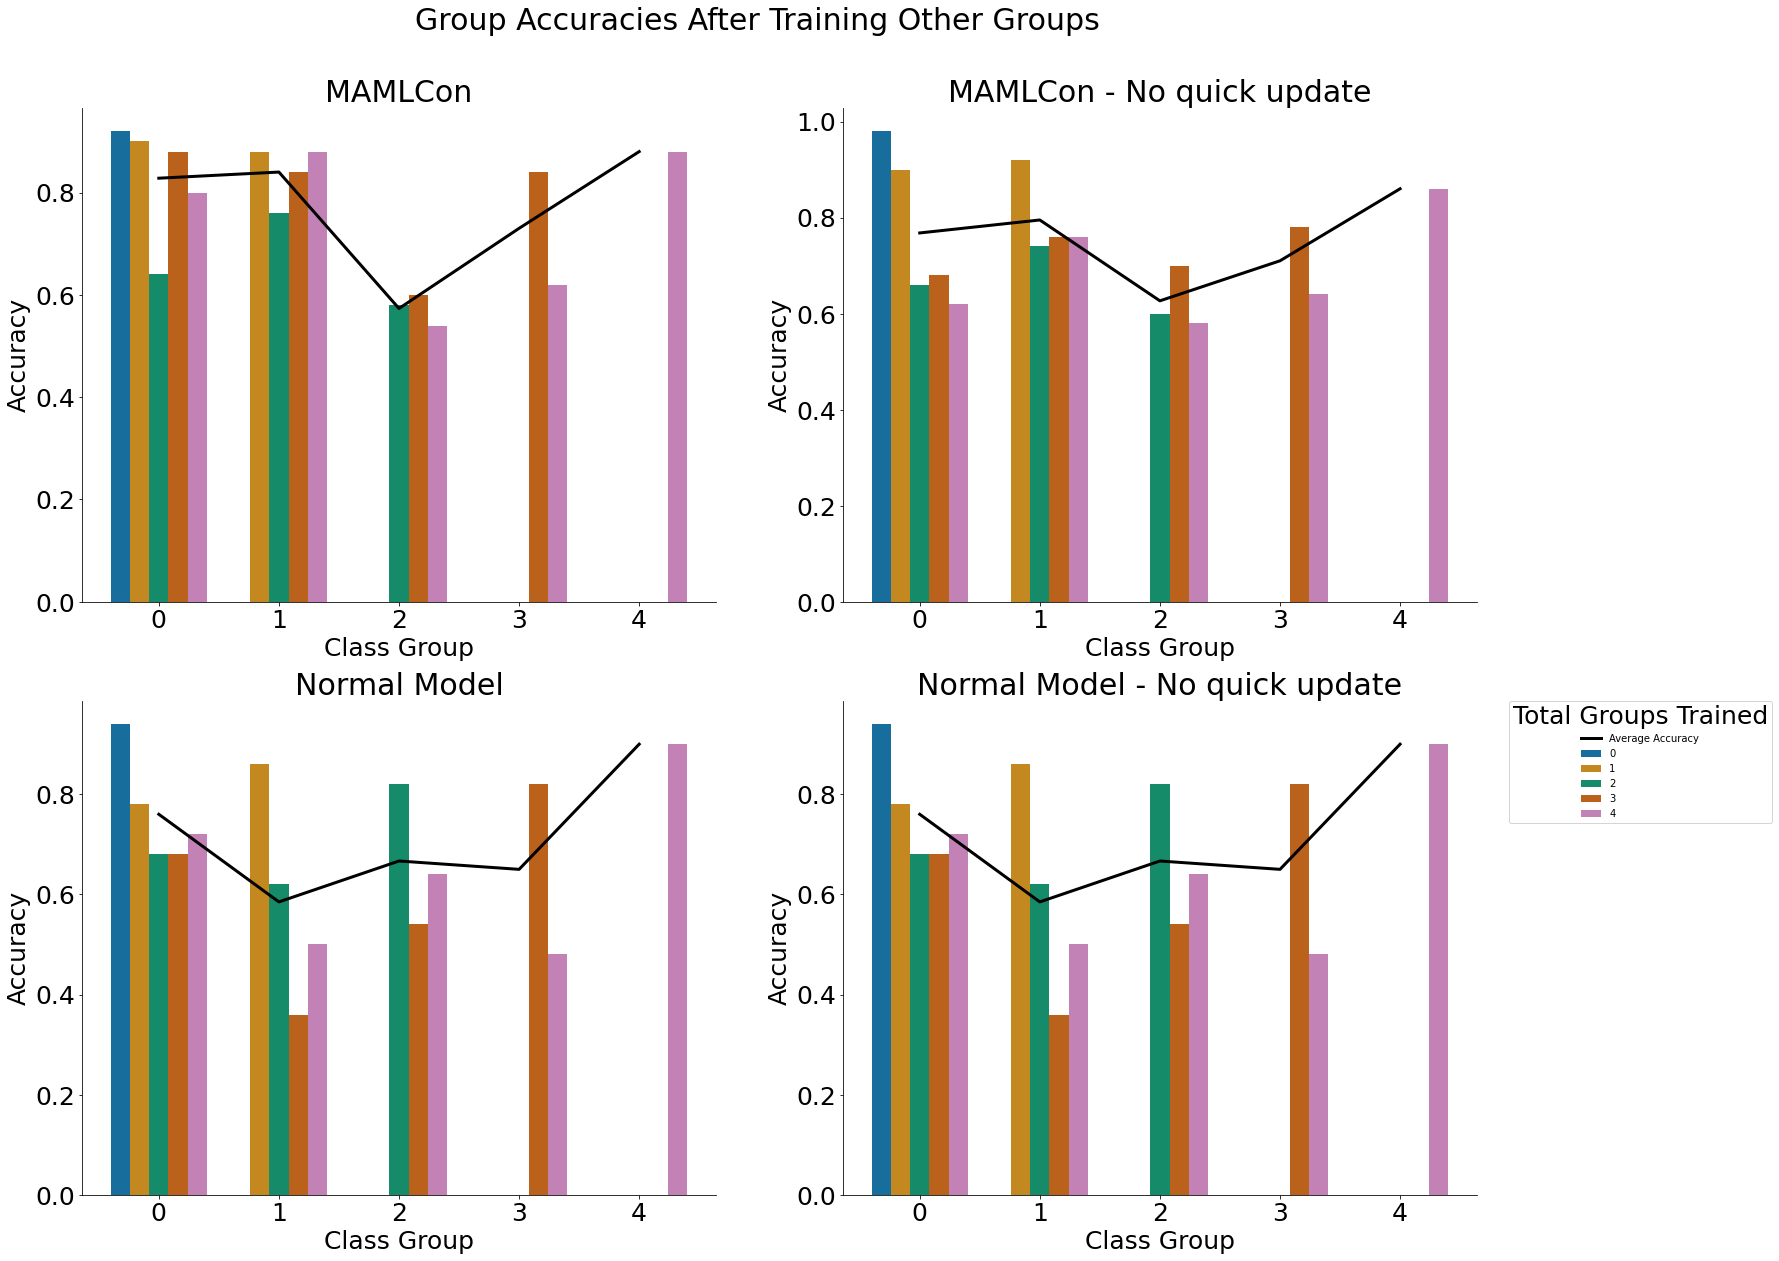

In [62]:
# make four subplots, one for MAMLCon and one for MAML
plt.figure(figsize=(25,20))

# set seaborn colour sceheme
sns.set_palette('colorblind')

# sns.set_palette()

ax1 = plt.subplot(221)
ax3 = plt.subplot(222)
ax2 = plt.subplot(223)
ax4 = plt.subplot(224)


plot_1_data = all_data[(all_data['MAMLCon']==True)&(all_data['quick_adapt']==True)&(all_data['N']==N)&(all_data['K']==K)]
g1=sns.barplot(x='group', y='accuracy', hue='training_group', data=plot_1_data, ax=ax1)
# put line plot on top of ax1 bar plot of average accuracy of each group
sns.lineplot(x='group', y='accuracy', data=plot_1_data.groupby('group').mean(), ax=ax1, color='black', linewidth=3)

plot_2_data = all_data[(all_data['MAMLCon']==False)&(all_data['quick_adapt']==True)&(all_data['N']==N)&(all_data['K']==K)]
g2=sns.barplot(x='group', y='accuracy', hue='training_group', data=plot_2_data, ax=ax2)
sns.lineplot(x='group', y='accuracy', data=plot_2_data.groupby('group').mean(), ax=ax2, color='black', linewidth=3, label='Average Accuracy')

g1.legend_.remove()
g2.legend_.remove()

# set titles
ax1.set_title('MAMLCon')
ax2.set_title('Normal Model')

# remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


plot_3_data = all_data[(all_data['MAMLCon']==True)&(all_data['quick_adapt']==False)&(all_data['N']==N)&(all_data['K']==K)]
g3=sns.barplot(x='group', y='accuracy', hue='training_group', data=plot_3_data, ax=ax3)
sns.lineplot(x='group', y='accuracy', data=plot_3_data.groupby('group').mean(), ax=ax3, color='black', linewidth=3)

plot_4_data = all_data[(all_data['MAMLCon']==False)&(all_data['quick_adapt']==True)&(all_data['N']==N)&(all_data['K']==K)]
g4=sns.barplot(x='group', y='accuracy', hue='training_group', data=plot_4_data, ax=ax4)
sns.lineplot(x='group', y='accuracy', data=plot_4_data.groupby('group').mean(), ax=ax4, color='black', linewidth=3, label='Average Accuracy')

g3.legend_.remove()
g4.legend_.remove()

# set titles
ax3.set_title('MAMLCon - No quick update')
ax4.set_title('Normal Model - No quick update')

# set all x labels to be blank
ax1.set_xlabel('Class Group')
ax2.set_xlabel('Class Group')
ax3.set_xlabel('Class Group')
ax4.set_xlabel('Class Group')

# set all x labels to be blank
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Accuracy')
ax3.set_ylabel('Accuracy')
ax4.set_ylabel('Accuracy')


# remove top and right spines
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)


# make plot font size bigger

# put legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Total Groups Trained', prop={'size': 10})

plt.rcParams.update({'font.size': 25})

# sup title closer to plots
plt.suptitle("Group Accuracies After Training Other Groups", y=0.95)

plt.savefig('group_accuracies.png', transparent=True, pad_inches=.2, frameon=False)
plt.show()

In [27]:
plot_1_data

,loss,accuracy,group,training_group,N,quick_adapt,MAMLCon,K
0,0.250000,0.92,0,0,10,True,True,5
1,0.480802,0.90,0,1,10,True,True,5
2,0.424737,0.88,1,1,10,True,True,5
3,1.266662,0.64,0,2,10,True,True,5
4,1.210459,0.76,1,2,10,True,True,5
5,1.477305,0.58,2,2,10,True,True,5
6,0.433661,0.88,0,3,10,True,True,5
7,0.611428,0.84,1,3,10,True,True,5
8,1.566029,0.60,2,3,10,True,True,5
9,0.556644,0.84,3,3,10,True,True,5


In [ ]:
plot_1_data = all_data[(all_data['MAMLCon']==True)&(all_data['quick_adapt']==True)&(all_data['N']==5)]

plot_2_data = all_data[(all_data['MAMLCon']==False)&(all_data['quick_adapt']==True)&(all_data['N']==5)]

plot_3_data = all_data[(all_data['MAMLCon']==True)&(all_data['quick_adapt']==False)&(all_data['N']==5)]

plot_4_data = all_data[(all_data['MAMLCon']==False)&(all_data['quick_adapt']==True)&(all_data['N']==5)]


In [ ]:
# sns.lineplot(x='group', y='accuracy', data=plot_1_data.groupby('group').mean(), ax=ax1, color='black', linewidth=3)
plt.figure(figsize=(20,10))
plt.plot(plot_1_data.groupby('group').mean().reset_index()['accuracy'], label='MAMLCon QA');
plt.plot(plot_2_data.groupby('group').mean().reset_index()['accuracy'], label='Normal QA');
plt.plot(plot_3_data.groupby('group').mean().reset_index()['accuracy'], label='MAMLCon');
plt.plot(plot_4_data.groupby('group').mean().reset_index()['accuracy'], label='Normal');
plt.legend()


In [ ]:
all_data[(all_data['MAMLCon']==True)&(all_data['quick_adapt']==True)&(all_data['N']==5)]

In [ ]:
all_data.N.unique()